In [5]:
# Uninstall the potentially incompatible versions
!pip uninstall -y gym numpy tensorflow jax

# Install a compatible version of gym and a specific version of numpy
!pip install gym==0.26.2 numpy==1.23.5 tensorflow jax

Found existing installation: gym 0.26.2
Uninstalling gym-0.26.2:
  Successfully uninstalled gym-0.26.2
Found existing installation: numpy 2.1.3
Uninstalling numpy-2.1.3:
  Successfully uninstalled numpy-2.1.3
Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: jax 0.6.2
Uninstalling jax-0.6.2:
  Successfully uninstalled jax-0.6.2
  Using cached gym-0.26.2-py3-none-any.whl
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
  Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached jax-0.6.2-py3-none-any.whl.metadata (13 kB)
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other re

In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# PPO Agent
class PPOAgent:
    def __init__(self, obs_dim, act_dim, gamma=0.99, clip_ratio=0.2, hidden_sizes=(64, 64)):
        self.gamma = gamma
        self.clip_ratio = clip_ratio
        self.act_dim = act_dim

        inputs = keras.Input(shape=(obs_dim,))
        x = inputs
        for size in hidden_sizes:
            x = layers.Dense(size, activation='tanh')(x)
        logits = layers.Dense(act_dim)(x)
        values = layers.Dense(1)(x)

        self.model = keras.Model(inputs=inputs, outputs=[logits, values])
        self.optimizer = keras.optimizers.Adam(learning_rate=3e-4)

    def get_action(self, state):
        state = np.expand_dims(state, axis=0).astype(np.float32)
        logits, value = self.model(state)
        probs = tf.nn.softmax(logits)
        action = np.random.choice(self.act_dim, p=probs.numpy()[0])
        return action, probs[0, action].numpy(), value[0, 0].numpy()

    def compute_returns(self, rewards, dones, last_value):
        returns = []
        R = last_value
        for r, done in zip(reversed(rewards), reversed(dones)):
            R = r + self.gamma * R * (1. - float(done))
            returns.insert(0, R)
        return returns

    def train(self, states, actions, old_probs, returns, advantages, epochs=5):
        actions = np.array(actions)
        old_probs = np.array(old_probs)
        returns = np.array(returns)
        advantages = np.array(advantages)

        for _ in range(epochs):
            with tf.GradientTape() as tape:
                logits, values = self.model(states)
                values = tf.squeeze(values)
                probs = tf.nn.softmax(logits)
                indices = tf.range(tf.shape(logits)[0]) * self.act_dim + actions
                probs = tf.gather(tf.reshape(probs, [-1]), indices)

                ratio = probs / old_probs
                clipped = tf.clip_by_value(ratio, 1.0 - self.clip_ratio, 1.0 + self.clip_ratio)
                policy_loss = -tf.reduce_mean(tf.minimum(ratio * advantages, clipped * advantages))
                value_loss = tf.reduce_mean((returns - values) ** 2)
                loss = policy_loss + 0.5 * value_loss

            grads = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))


In [2]:
def run_training(env_name="CartPole-v1", epochs=5, hidden_sizes=(64, 64), clip_ratio=0.2):
    env = gym.make(env_name)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n
    agent = PPOAgent(obs_dim, act_dim, clip_ratio=clip_ratio, hidden_sizes=hidden_sizes)

    all_returns, all_lengths = [], []

    for epoch in range(epochs):
        states, actions, rewards, dones, probs, values = [], [], [], [], [], []
        obs = env.reset()
        if isinstance(obs, tuple): obs = obs[0]
        ep_len = ep_ret = 0

        while len(states) < 2048:
            action, prob, val = agent.get_action(obs)
            step_result = env.step(action)
            if len(step_result) == 5:
                next_obs, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            else:
                next_obs, reward, done, _ = step_result

            states.append(obs)
            actions.append(action)
            rewards.append(reward)
            dones.append(done)
            probs.append(prob)
            values.append(val)

            obs = next_obs
            ep_len += 1
            ep_ret += reward

            if done:
                all_returns.append(ep_ret)
                all_lengths.append(ep_len)
                obs = env.reset()
                if isinstance(obs, tuple): obs = obs[0]
                ep_ret = ep_len = 0

        _, _, last_val = agent.get_action(obs)
        returns = agent.compute_returns(rewards, dones, last_val)
        advs = np.array(returns) - np.array(values)

        agent.train(np.array(states), actions, probs, returns, advs)
        print(f"Epoch {epoch+1} — Return: {np.mean(all_returns[-10:]):.2f} | Length: {np.mean(all_lengths[-10:]):.2f}")

    return all_returns, all_lengths


In [3]:
def plot_results(returns, lengths, title):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(returns)
    plt.title(f'{title} — Return')
    plt.subplot(1, 2, 2)
    plt.plot(lengths)
    plt.title(f'{title} — Length')
    plt.show()


Epoch 1 — Return: 32.80 | Length: 32.80
Epoch 2 — Return: 41.40 | Length: 41.40
Epoch 3 — Return: 45.40 | Length: 45.40
Epoch 4 — Return: 35.90 | Length: 35.90
Epoch 5 — Return: 41.50 | Length: 41.50


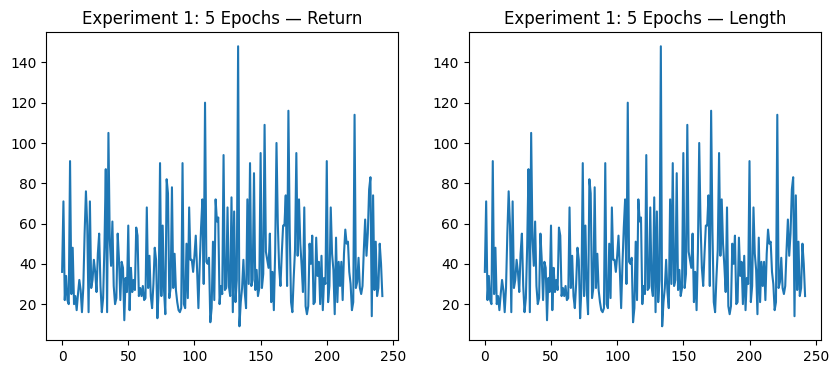

Epoch 1 — Return: 19.10 | Length: 19.10
Epoch 2 — Return: 26.70 | Length: 26.70
Epoch 3 — Return: 36.80 | Length: 36.80
Epoch 4 — Return: 37.00 | Length: 37.00
Epoch 5 — Return: 46.60 | Length: 46.60


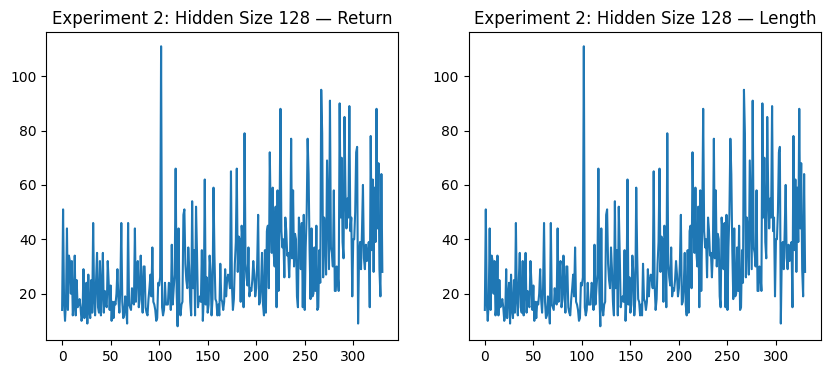

Epoch 1 — Return: 19.30 | Length: 19.30
Epoch 2 — Return: 22.60 | Length: 22.60
Epoch 3 — Return: 27.40 | Length: 27.40
Epoch 4 — Return: 26.90 | Length: 26.90
Epoch 5 — Return: 28.40 | Length: 28.40


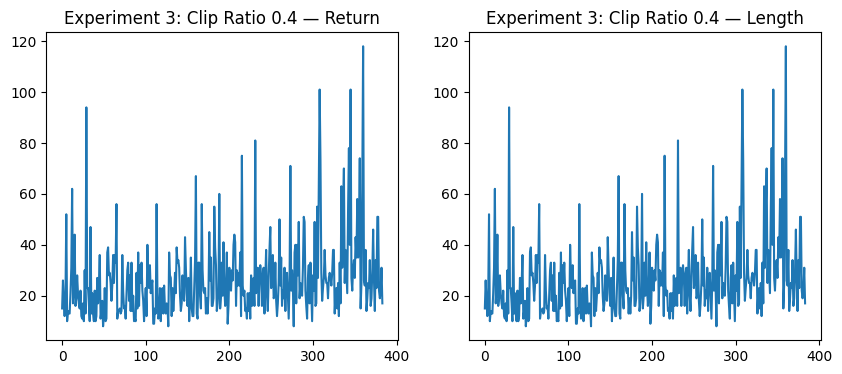

In [5]:
r1, l1 = run_training(epochs=5)
plot_results(r1, l1, "Experiment 1: 5 Epochs")

r2, l2 = run_training(epochs=5, hidden_sizes=(128, 128))
plot_results(r2, l2, "Experiment 2: Hidden Size 128")

r3, l3 = run_training(epochs=5, clip_ratio=0.4)
plot_results(r3, l3, "Experiment 3: Clip Ratio 0.4")

Experiment 1, with only 5 training epochs, the PPO agent demonstrated clear improvement in both mean return and episode length. This shows that PPO can learn a reasonably effective policy within a short training window, though further training is likely needed for full mastery.

Experiment 2 , Increasing the hidden layer size to (128, 128) slightly improved early learning stability, but did not lead to a dramatic change in performance after just 5 epochs. Longer training may be needed to realize full benefits of a deeper network.


Experiment 3 , Increasing the clip ratio to 0.4 resulted in slower and less stable learning. PPO likely benefits from smaller, conservative updates (e.g., 0.2), as large changes may cause policy degradation during early training.


